In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

##### Функции из базовой части лабораторной работы.

In [2]:
def qubic_spline_coeff(x_nodes, y_nodes):
    n = len(x_nodes)
    a = list(y_nodes)
    
    h = [x_nodes[i + 1] - x_nodes[i] for i in range(n - 1)] 
    
    alph = [3 / h[i] * (a[i + 1] - a[i]) 
         - 3 / h[i - 1] * (a[i] - a[i - 1]) for i in range(1, n - 1)]
    
    l = [1 for i in range(n)]
    mu = [0 for i in range(n - 1)]
    z = [0 for i in range(n)]
    
    for i in range(1, n - 1):
        l[i] = 2 * (x_nodes[i + 1] - x_nodes[i - 1]) - h[i - 1] * mu[i - 1]
        mu[i] = h[i] / l[i] 
        z[i] = (alph[i - 1] - h[i - 1] * z[i - 1]) / l[i]
        
    c = [0 for i in range(n)]
    b = [0 for i in range(n - 1)]
    d = [0 for i in range(n - 1)]
    
    for j in range(n - 1, 0, -1):
        c[j - 1] = z[j - 1] - mu[j - 1] * c[j]
        b[j - 1] = ((a[j] - a[j - 1]) / h[j - 1] 
                    - h[j - 1] * (c[j] + 2 * c[j - 1]) / 3)
        d[j - 1] = (c[j] - c[j - 1]) / 3 / h[j - 1]
        
    c.pop(-1)
    a.pop(-1)
    
    matr = np.c_[a, b, c, d]
    
    return matr

In [3]:
def qubic_spline(x, x_nodes, qs_coeff):
    
    for i in range(len(x_nodes) - 1):
        if x <= x_nodes[i + 1]:
            break
            
    return (qs_coeff[i][0] + qs_coeff[i][1] * (x - x_nodes[i]) 
            + qs_coeff[i][2] * (x - x_nodes[i]) ** 2 
            + qs_coeff[i][3] * (x - x_nodes[i]) ** 3)   

In [4]:
def d_qubic_spline(x, x_nodes, qs_coeff):
    
    for i in range(len(x_nodes) - 1):
        if x <= x_nodes[i + 1]:
            return (qs_coeff[i][1] + 2 * qs_coeff[i][2] * (x - x_nodes[i]) 
                    + 3 * qs_coeff[i][3] * (x - x_nodes[i]) ** 2)
            
    return None

Функция graphic(x, y, n = 0)  реализует построение необходимых графиков. Здесь первые два параметра - список значений х и список (либо матрица) значений у. Последний параметр указывает на то, сколько графиков на одной координатной плоскости необходимо построить. Если он равен 0, то строится один график, если не равен нулю, то строится семейство графиков размером n, при этом значения по х остаются одинаковыми для всех y. Такая реализация понадобится в дальнейшем для решения продвинутой части лабораторной работы.

In [51]:
def graphic(x, y, n = 0):
    fig = plt.figure(figsize=(15, 12))
    plt.xlabel('x', fontsize=24, color='blue')
    plt.ylabel('y', fontsize=24, color='blue')
    plt.rcParams.update({'font.size': 20})
    
    if n:
        for i in range(n):
            plt.plot(x, y[i])
    else:
        plt.plot(x, y)
        
    plt.grid(True)

Функция nodes(x_nodes, y_nodes) выводит узлы интерполяции.

In [6]:
def nodes(x_nodes, y_nodes):
        for i in range(len(x_nodes)):
            plt.scatter(x_nodes[i], y_nodes[i], color='red', s=40, marker='o')

Функция line(x, x1, y1, x_nodes, matr) строит касательную к кубическому сплайну в заданных узлах. Пользуясь уравнением касательной в точке (x1, f(x1)) y = f'(x1) * (x1)(x - x1) + f(x1), получаем, что параметры обладают следующим смыслом: х - аргумент функции, являющейся касательной к сплайну в точке (x1, y1), а параметры x_nodes и matr необходимы для вычисления значения производной сплайна в данной точке (x1, y1).

In [7]:
def line(x, x1, y1, x_nodes, matr):
    return d_qubic_spline(x1, x_nodes, matr) * (x - x1) + y1

Функция derivative(x_nodes, y_nodes, matr) непостредственно выводит касательные к сплайну в заданных узлах. Две этих функции line(x, x1, y1, x_nodes, matr) и derivative(x_nodes, y_nodes, matr) реализованы ради демонстрации работы функции d_qubic_spline(x, x_nodes, qs_coeff). 

In [8]:
def derivative(x_nodes, y_nodes, matr):
    for j in range(1, len(x_nodes) - 1):
            xrange = np.linspace(x_nodes[j] - 0.05, x_nodes[j] + 0.05, 6)
            plt.plot(xrange, line(xrange, x_nodes[j], y_nodes[j], x_nodes, matr), 'C1--', linewidth = 2)

##### Функции из продвинутой части лабораторной работы.

In [9]:
def l_i(i, x, x_nodes):
    
    n = len(x_nodes)
    p = 1
    
    for j in range(n):
        if j != i:
            p *= (x - x_nodes[j]) / (x_nodes[i] - x_nodes[j])
    return p

In [10]:
def L(x, x_nodes, y_nodes):
    
    n = len(x_nodes)
    s = 0
    
    for i in range(n):
        s += y_nodes[i] * l_i(i, x, x_nodes)
    
    return s

In [11]:
def conf_band(y, n):
    y_ = y.transpose()
    for i in range(n + 1):
        y_[i].sort()
        
    h_l = [(y_[i][48] + y_[i][49]) / 2 for i in range(n + 1)]
    h_m = [sum(y_[i]) / 1000 for i in range(n + 1)]
    h_u = [(y_[i][948] + y_[i][949]) / 2 for i in range(n + 1)]
    
    return [h_l, h_m, h_u]

Входные данные

In [12]:
x_n = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_n = [3.37, 3.95, 3.73, 3.59, 3.15, 3.15, 3.05, 3.86, 3.60, 3.70, 3.02]

Базовая часть

In [13]:
n = 200
matr = qubic_spline_coeff(x_n, y_n)
x = [i / n for i in np.arange(0, n + 1)]
q = [qubic_spline(x[i], x_n, matr) for i in range(0, n + 1)]

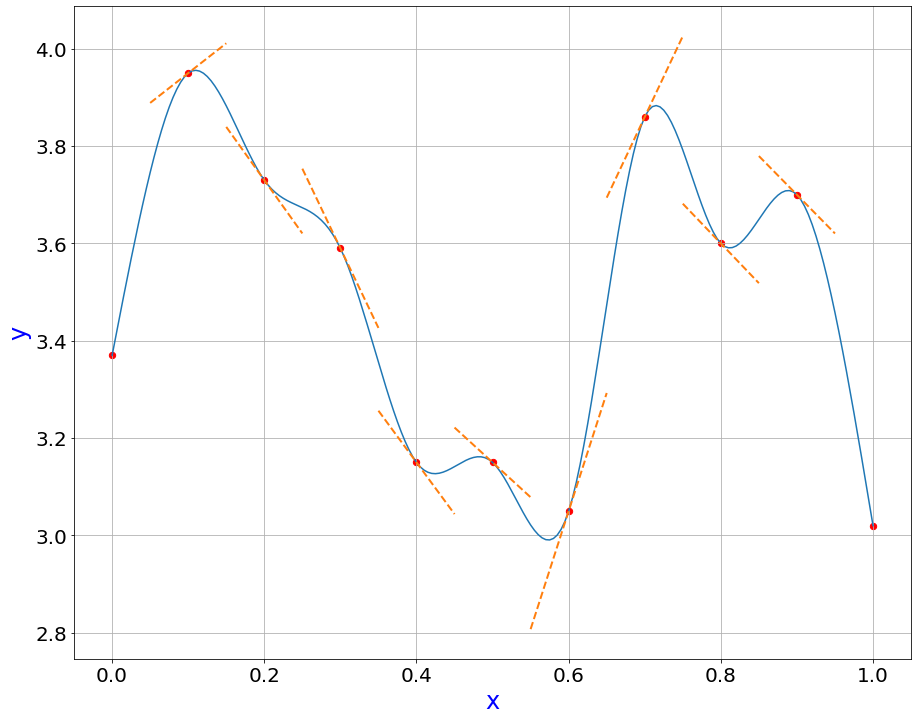

In [63]:
graphic(x, q)
nodes(x_n, y_n)
derivative(x_n, y_n, matr)

Продвинутая часть

In [15]:
l = [L(x[i], x_n, y_n) for i in range(0, n + 1)]

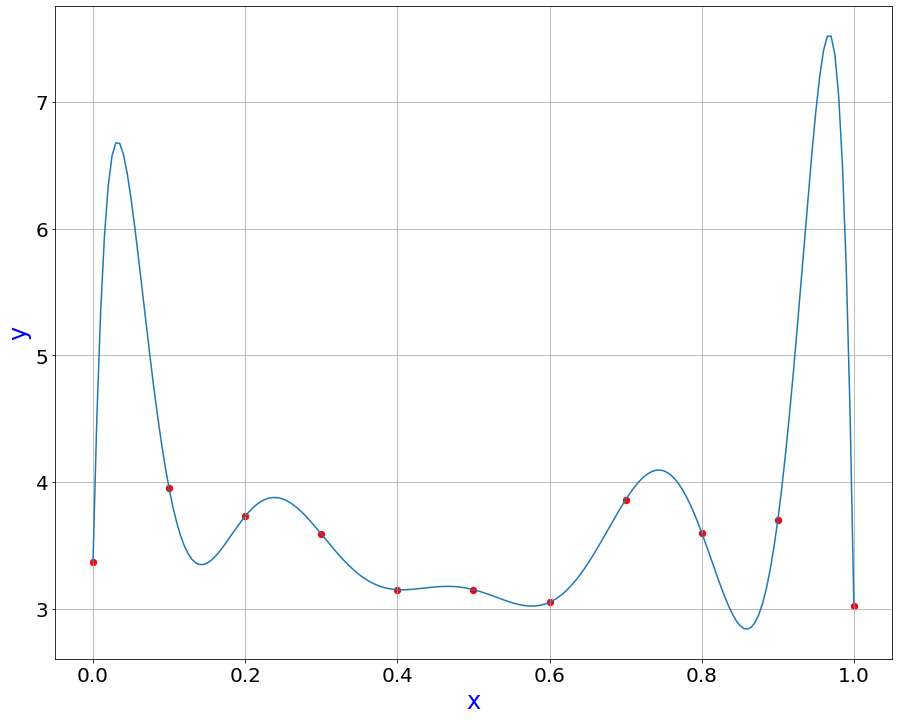

In [53]:
graphic(x, l)
nodes(x_n, y_n)

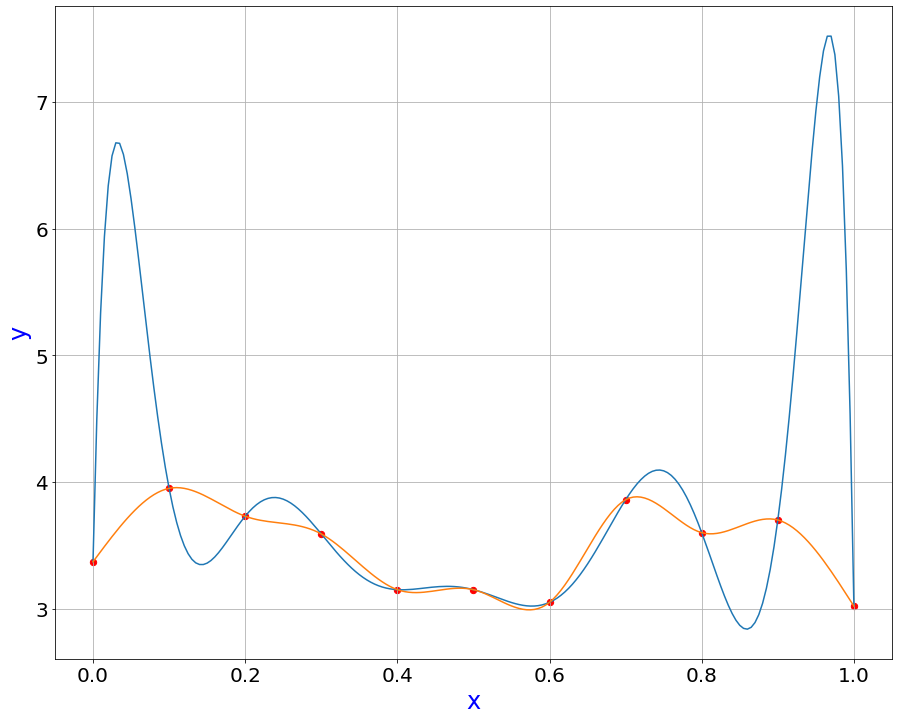

In [54]:
graphic(x, [l, q], 2)
nodes(x_n, y_n)

In [18]:
mu, sigma = 0, 0.01
m, k = len(x_n), len(y_n)

x_generate = [[x_n[i] +  np.random.normal(mu, sigma) 
               for i in range(m)] for j in range(1000)]
h_generate = [[y_n[i] +  np.random.normal(mu, sigma) 
               for i in range(k)] for j in range(1000)]

lx_generate = [[L(x[i], x_generate[j], y_n) 
                for i in range(0, n + 1)] for j in range(1000)]
ly_generate = [[L(x[i], x_n, h_generate[j]) 
                for i in range(0, n + 1)] for j in range(1000)]
qx_generate = [[qubic_spline(x[i], x_generate[j], qubic_spline_coeff(x_generate[j], y_n))
                for i in range(0, n + 1)] for j in range(1000)]
qy_generate = [[qubic_spline(x[i],  x_n, qubic_spline_coeff(x_n, h_generate[j]))
                for i in range(0, n + 1)] for j in range(1000)]

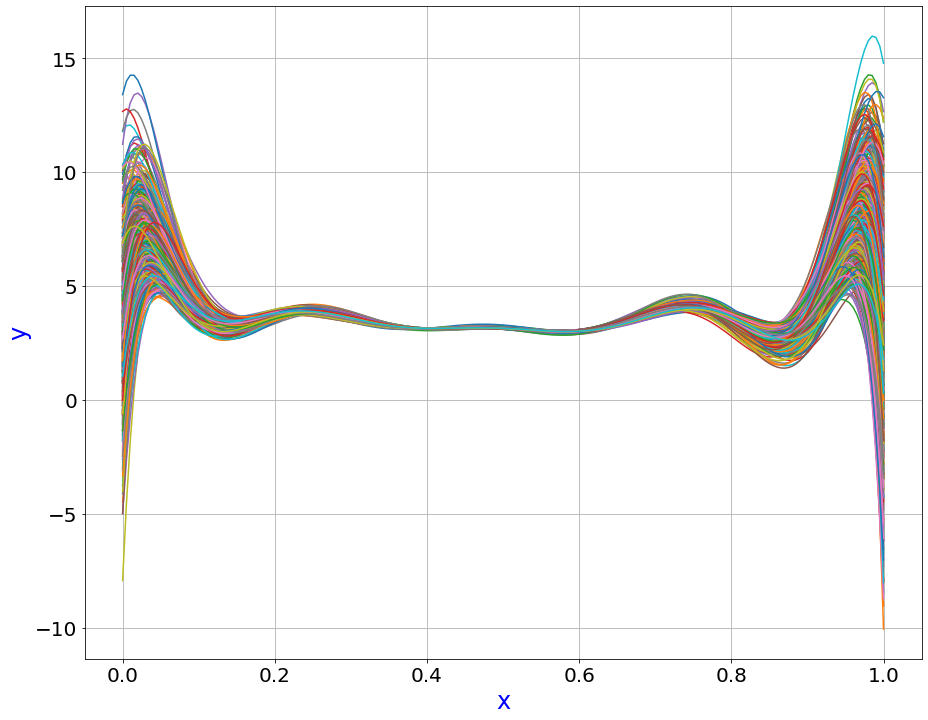

In [55]:
graphic(x, lx_generate, 1000)

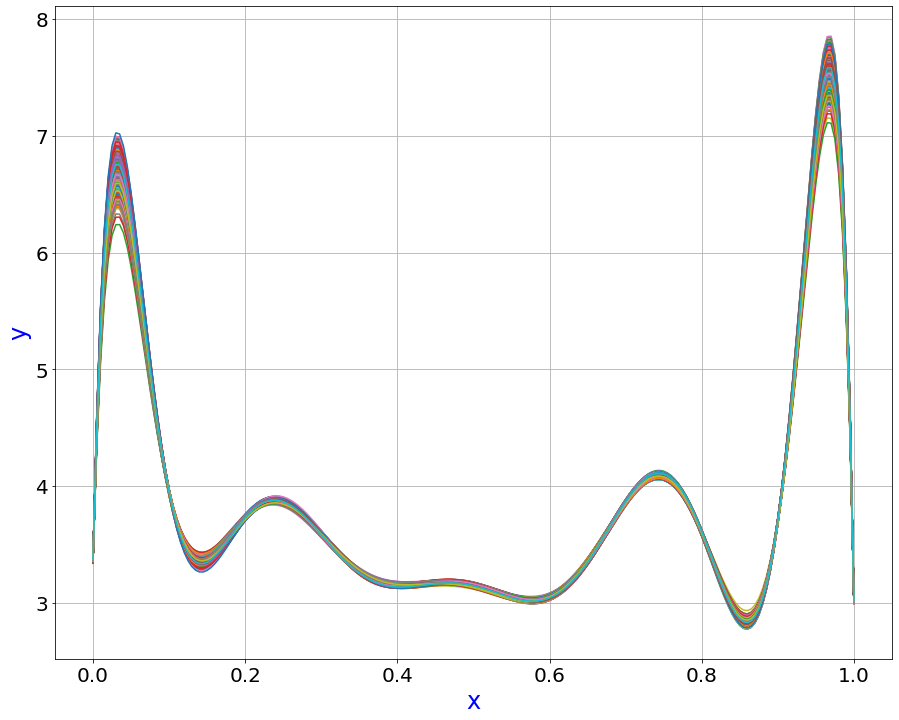

In [56]:
graphic(x, ly_generate, 1000)

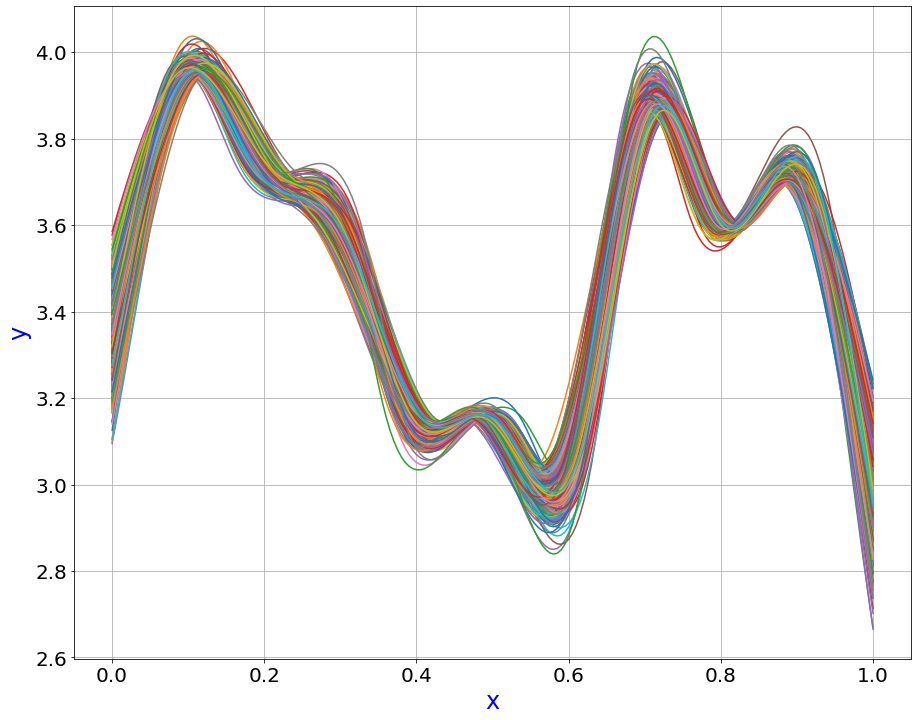

In [57]:
graphic(x, qx_generate, 1000)

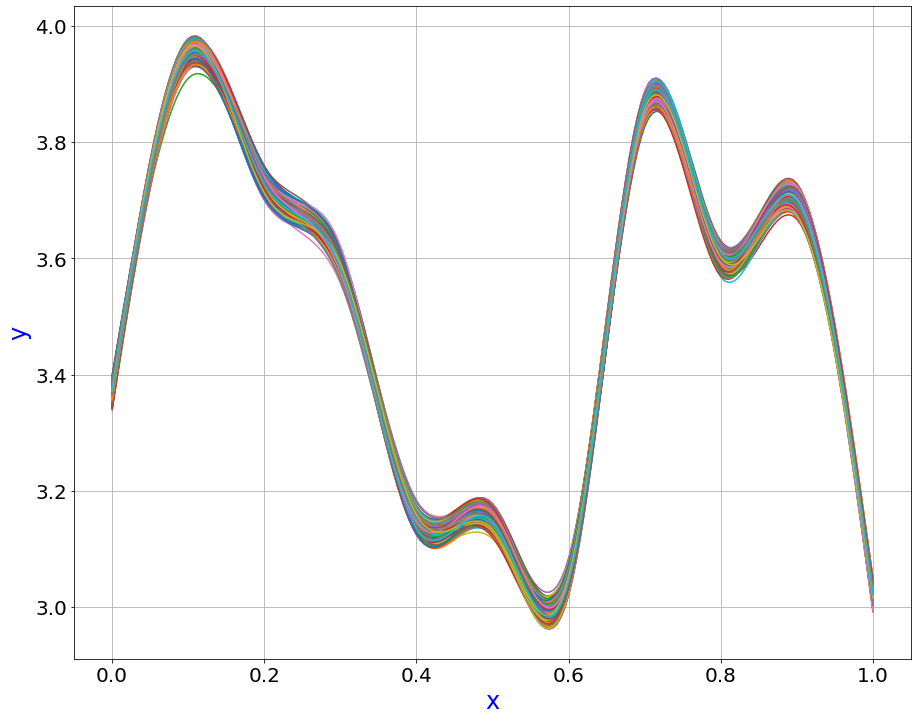

In [58]:
graphic(x, qy_generate, 1000)

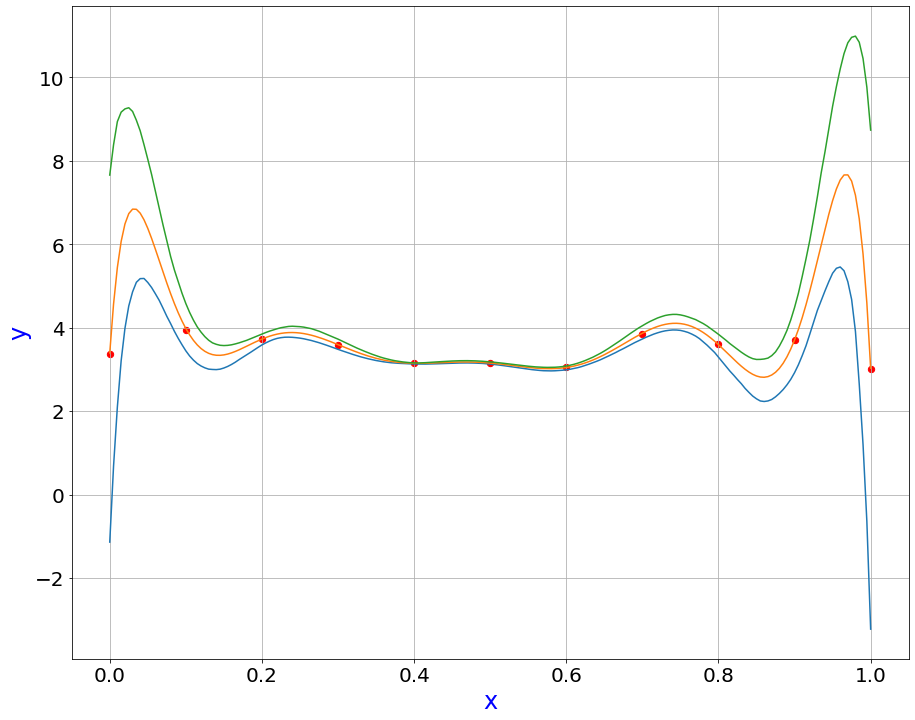

In [59]:
h_1 = conf_band(np.array(lx_generate), n)
graphic(x, h_1, 3)
nodes(x_n, y_n)

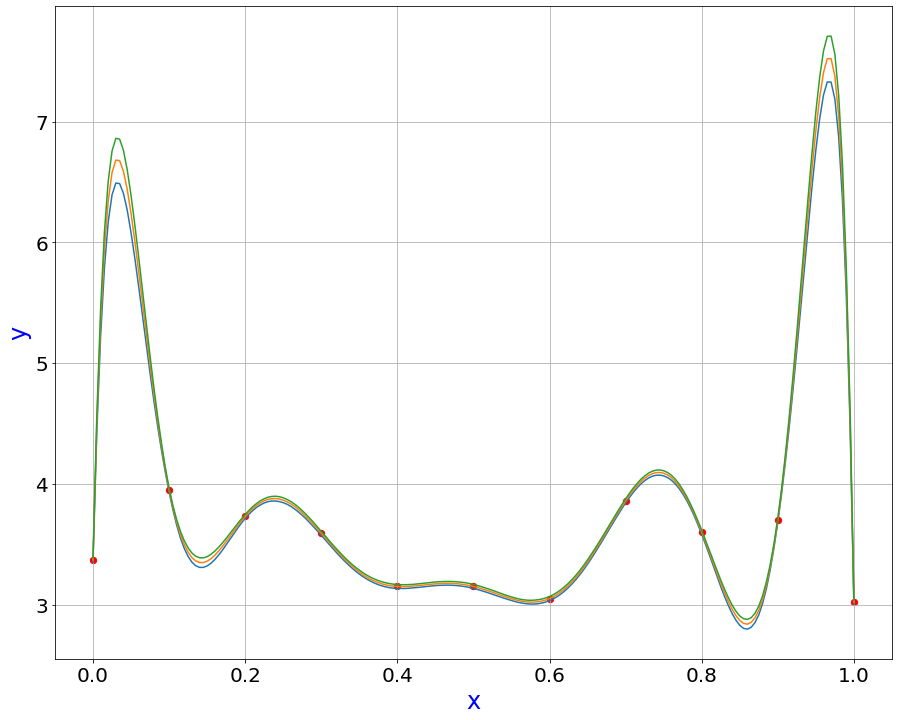

In [60]:
h_2 = conf_band(np.array(ly_generate), n)
graphic(x, h_2, 3)
nodes(x_n, y_n)

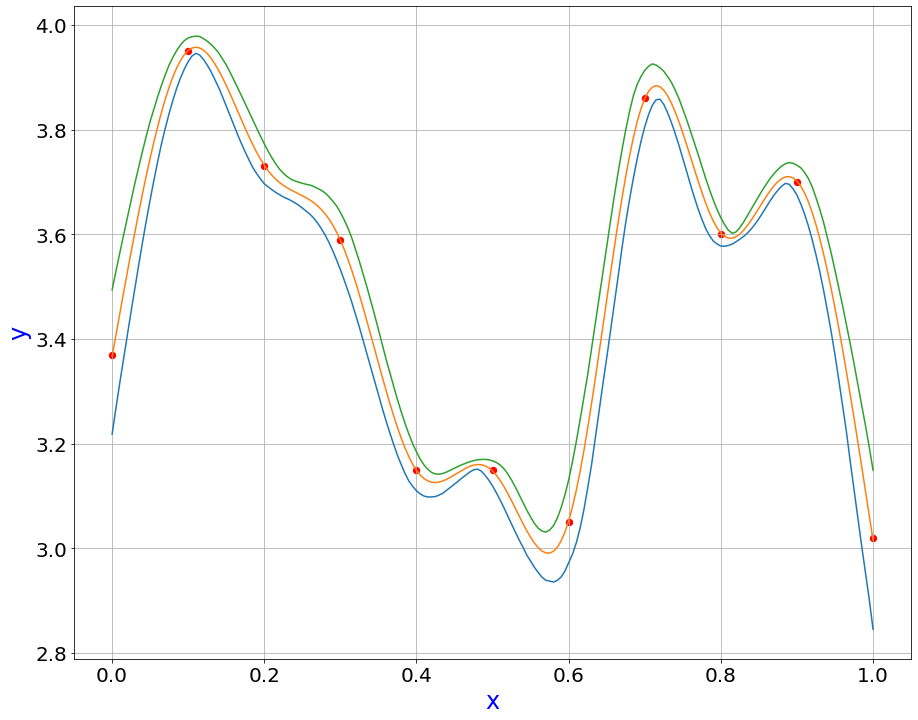

In [61]:
h_3 = conf_band(np.array(qx_generate), n)
graphic(x, h_3, 3)
nodes(x_n, y_n)

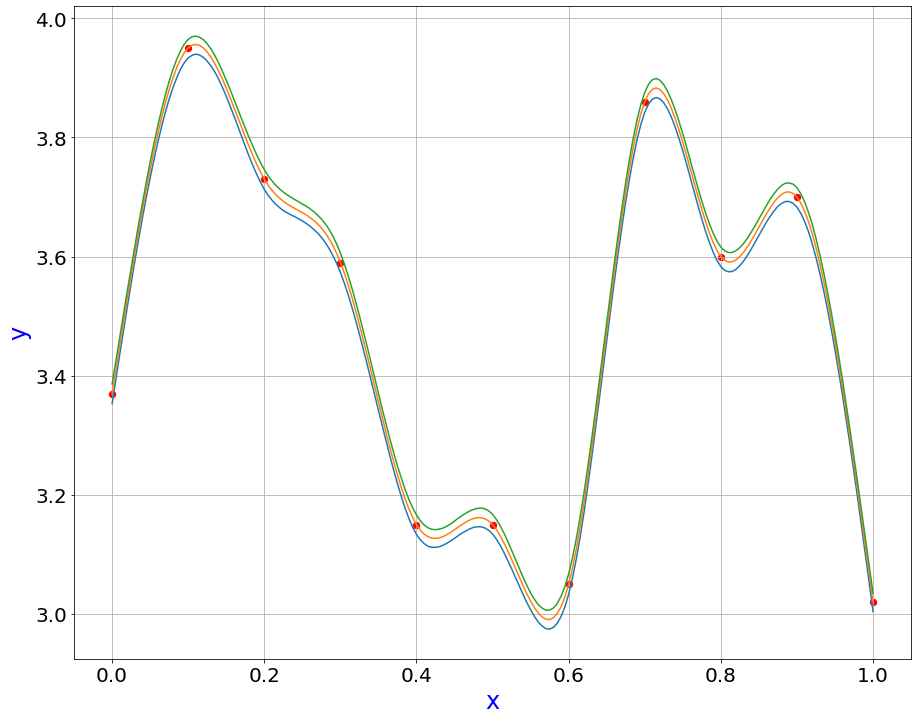

In [62]:
h_4 = conf_band(np.array(qy_generate), n)
graphic(x, h_4, 3)
nodes(x_n, y_n)

In [27]:
import pandas as pd

In [28]:
df1 = pd.DataFrame({
    'Лагранж, x' : h_1[1],
    'Лагранж, h' : h_2[1],
    'Лагранж' : l,
    'Сплайн, x' : h_3[1],
    'Сплайн, h' : h_4[1],
    'Сплайн' : q
})

In [29]:
df1.head(15)

,"Лагранж, x","Лагранж, h",Лагранж,"Сплайн, x","Сплайн, h",Сплайн
0,3.393361,3.370210,3.370000,3.366870,3.370210,3.370000
1,4.566258,4.496086,4.494958,3.407440,3.410642,3.410408
2,5.442847,5.337397,5.335577,3.447899,3.450902,3.450645
3,6.069885,5.939111,5.936792,3.488065,3.490819,3.490539
4,6.488754,6.341021,6.338364,3.527758,3.530220,3.529918
5,6.735925,6.578189,6.575329,3.566796,3.568935,3.568611
6,6.843399,6.681375,6.678423,3.604998,3.606791,3.606446
7,6.839115,6.677428,6.674476,3.642184,3.643617,3.643251
8,6.747330,6.589653,6.586772,3.678173,3.679240,3.678856
9,6.588973,6.438152,6.435398,3.712783,3.713490,3.713088


In [30]:
df2 = pd.DataFrame({
    'Лагранж, x, hl' : h_1[0],
    'Лагранж, h, hl' : h_2[0],
    'Лагранж, x, hu' : h_1[2],
    'Лагранж, h, hu' : h_2[2],
    'x' : x
})

In [31]:
df2.head(21)

,"Лагранж, x, hl","Лагранж, h, hl","Лагранж, x, hu","Лагранж, h, hu",x
0,-1.141752,3.353102,7.659965,3.386143,0.000
1,0.678443,4.427928,8.385957,4.559554,0.005
2,2.096533,5.221001,8.941752,5.448480,0.010
3,3.209327,5.787035,9.169519,6.084063,0.015
4,3.988192,6.168514,9.247275,6.507414,0.020
5,4.521292,6.393403,9.274889,6.755571,0.025
6,4.858994,6.491215,9.186320,6.861928,0.030
7,5.089203,6.487279,8.974797,6.855630,0.035
8,5.176515,6.406320,8.722524,6.762216,0.040
9,5.180573,6.266809,8.390826,6.600756,0.045


In [32]:
df3 = pd.DataFrame({
    'Сплайн, x, hl' : h_3[0],
    'Сплайн, h, hl' : h_4[0],
    'Сплайн, x, hu' : h_3[2],
    'Сплайн, h, hu' : h_4[2],
    'x' : x
})

In [33]:
df3.head(21)

,"Сплайн, x, hl","Сплайн, h, hl","Сплайн, x, hu","Сплайн, h, hu",x
0,3.218215,3.353102,3.493812,3.386143,0.000
1,3.267740,3.394641,3.529519,3.425633,0.005
2,3.315591,3.435736,3.563875,3.465046,0.010
3,3.361758,3.476101,3.598130,3.504328,0.015
4,3.407116,3.515837,3.631560,3.543010,0.020
5,3.453173,3.555344,3.664231,3.580878,0.025
6,3.498116,3.593418,3.698284,3.618745,0.030
7,3.541904,3.630317,3.729157,3.655980,0.035
8,3.585223,3.666004,3.759170,3.691314,0.040
9,3.626589,3.699729,3.788585,3.725871,0.045


Здесь происходит вычисление среднего значения абсолютного отклонения среднего выборочного от матожидания.

In [34]:
f_ = [l, q]
h_ = [h_1[1], h_2[1], h_3[1], h_4[1]]
abs_ = [0 for i in range(4)]

for j in range(2):
    for i in range(201):
        abs_[j] += abs(h_[j][i] - f_[0][i])
        abs_[j + 2] += abs(h_[j + 2][i] - f_[1][i])
        
for i in range(4):
    abs_[i] /= 201
    
print(abs_)

[0.02484022454783252, 0.00038394341273687, 0.0013057615231120102, 0.0001726319638688876]
